# Golden Section Search

In [1]:
import numpy as np
import typing
from numpy import typing as nptyping
import scipy as sp
import scipy.optimize as op
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [11]:
def golden_section(
    f: typing.Callable[[float], float],
    boundary: nptyping.ArrayLike,
    maxiter=500,
    tol=1e-5,
):
    r = (-1 + np.sqrt(5)) / 2  # golden ratio
    a = boundary[0]  # lower bound
    b = boundary[1]  # upper bound

    for _ in range(maxiter):
        h = b - a
        if abs(h) < tol:
            return (a + b) / 2
        lower = b - r * h
        upper = a + r * h

        if f(lower) > f(upper):
            a = lower
        else:
            b = upper

    print("Warning: Did not converge within given number of iteration.")
    return (a + b) / 2

3.9269887262718806


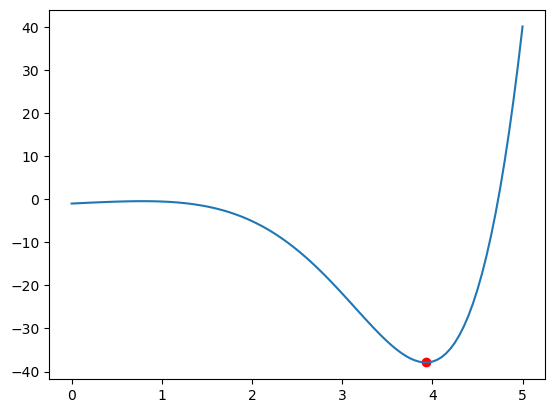

In [15]:
# Example of Golden Section Search
f = lambda x: np.exp(x) * np.cos(x) - 2
minimum = golden_section(f, [1, 5])
print(minimum)

xrange = np.linspace(0, 5, 101)
plt.plot(xrange, f(xrange))
plt.scatter(minimum, f(minimum), color="r")

# Gradient Descent

In [53]:
from differentiation import gradient


def gradient_descent(
    f: typing.Callable[[nptyping.ArrayLike], float],
    x0: nptyping.ArrayLike,
    grad_f=None,
    step=0.01,
    maxiter=10000,
    tol=1e-6,
    traj: bool = False,
) -> float:
    x = x0
    if grad_f is None:
        if traj:
            trajectory = np.empty((3, maxiter))
            for i in range(maxiter):
                trajectory[0:2, i] = x
                trajectory[2, i] = f(x)
                if abs(np.linalg.norm(gradient(f, x), 2)) < tol:
                    return x, trajectory[:, : i + 1]

                x -= step * gradient(f, x)
            print("Warning: Did not converge within given number of iteration.")
            return x, trajectory
        else:
            for i in range(maxiter):
                if abs(np.linalg.norm(gradient(f, x), 2)) < tol:
                    return x

                x -= step * gradient(f, x)
            print("Warning: Did not converge within given number of iteration.")
            return x
    else:
        for _ in range(maxiter):
            if abs(np.linalg.norm(grad_f(x), 2)) < tol:
                return x

            x -= step * grad_f(f, x)
        print("Warning: Did not converge within given number of iteration.")
        return x

In [6]:
from differentiation import gradient


def gradient_descent2(f, x0: np.ndarray, grad_f=None, maxiter=100000, tol=1e-6):
    """
    Returns minimum optimized by gradient descent.
    Ver2 uses adaptive step size valid when:
    f is convex and grad(f) is Lipschitz continuous
    """
    if ~isinstance(x0, np.ndarray):
        x0 = np.array(x0)

    x_old = x0
    x = x_old + 0.5

    for _ in range(maxiter):
        if abs(np.linalg.norm(gradient(f, x), 2)) < tol:
            return x
        # Calculation of step is causing a problem
        step = abs(np.dot((x - x_old).T, (gradient(f, x) - gradient(f, x_old))))
        step /= np.linalg.norm(gradient(f, x) - gradient(f, x_old)) ** 2

        x_old = x
        x -= step * gradient(f, x)
    print("Warning: Did not converge within given number of iteration.")
    return x

Minimum point >> [-3.09835401e-06 -3.09835401e-06]
Iteration >> 3


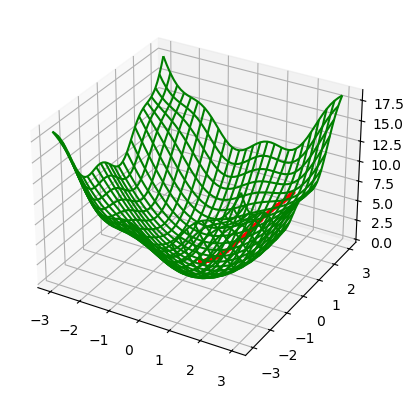

In [54]:
def my_func(x_vect: nptyping.ArrayLike):
    x = x_vect[0]
    y = x_vect[1]
    return x**2 + y**2 + np.sin(x * y)


minimum, traj = gradient_descent(my_func, [2.0, 2.0], traj=True)

fig = plt.figure()
ax = plt.axes(projection="3d")
xrange = np.linspace(-3, 3, 51)
yrange = np.linspace(-3, 3, 51)
xgrid, ygrid = np.meshgrid(xrange, yrange)
zgrid = my_func([xgrid, ygrid])

ax.plot_wireframe(xgrid, ygrid, zgrid, color="green")
ax.plot(traj[0, :], traj[1, :], traj[2, :], "ro-", markersize=2)
print(f"Minimum point >> {minimum}")
print(f"Iteration >> {len(traj)}")

# Nelder-Mead Method

In [58]:
# All vectors in column vector form!
def _centroid(X):
    n = len(X)
    x0 = np.sum(X[:, :-1], axis=1) / n
    return x0


def _reflection(x0, X, alpha):
    x_r = x0 + alpha * (x0 - X[:, -1])
    return x_r


def _expansion(x0, x_r, gamma):
    x_e = x0 + gamma * (x_r - x0)
    return x_e


def _contraction_out(x0, x_r, rho):
    x_c = x0 + rho * (x_r - x0)
    return x_c


def _contraction_in(x0, X, rho):
    x_c = x0 + rho * (X[:, -1] - x0)
    return x_c


def _shrink(X, phi):
    X_shrink = X[:, 0] + phi * (X - X[:, 0])
    return X_shrink


def nelder_mead(
    f: typing.Callable[[np.ndarray], float],
    X0: np.ndarray,
    alpha: float = 1.0,
    gamma: float = 2.0,
    rho: float = 0.5,
    phi: float = 0.5,
    maxiter: float = 1e5,
    tol: float = 1e-6,
    traj: bool = False,
) -> np.ndarray:
    """
    Returns minimum optimized by Nelder-Mead method.
    """
    X = X0
    if traj:
        n = len(X0[:, 0])
        trajectory = np.empty((n, n + 1, int(maxiter)))

    for iter in range(int(maxiter)):
        sort_idx = np.argsort(f(X))
        X = np.array([X[:, i] for i in sort_idx]).T

        if traj:
            # Only the coordinates are stored in the trajectory.
            # Should substitute into function to get value.
            trajectory[:, 0, iter] = X[:, 0]
            trajectory[:, 1:, iter] = X[:, -n:]

        if np.std(f(X)) < tol:
            if traj:
                return X[:, 0], trajectory[:, :, : iter + 1]
            else:
                return X[:, 0]

        x0 = _centroid(X)
        x_r = _reflection(x0, X, alpha)
        if f(x_r) >= f(X[:, 0]) and f(x_r) < f(X[:, -2]):
            X[:, -1] = x_r
        elif f(x_r) < f(X[:, 0]):
            x_e = _expansion(x0, x_r, gamma)
            if f(x_e) < f(x_r):
                X[:, -1] = x_e
            else:
                X[:, -1] = x_r
        else:
            if f(x_r) < f(X[:, -1]):  # Outside the simplex
                x_c = _contraction_out(x0, x_r, rho)
                if f(x_c) < f(x_r):
                    X[:, -1] = x_c
                else:
                    X = _shrink(X, phi)
            else:  # Inside the simplex
                x_c = _contraction_in(x0, X, rho)
                if f(x_c) < f(X[:, -1]):
                    X[:, -1] = x_c
                else:
                    X = _shrink(X, phi)
    print("Warning: Did not converge within given number of iteration.")
    if traj:
        return X[:, 0], trajectory
    else:
        return X[:, 0]

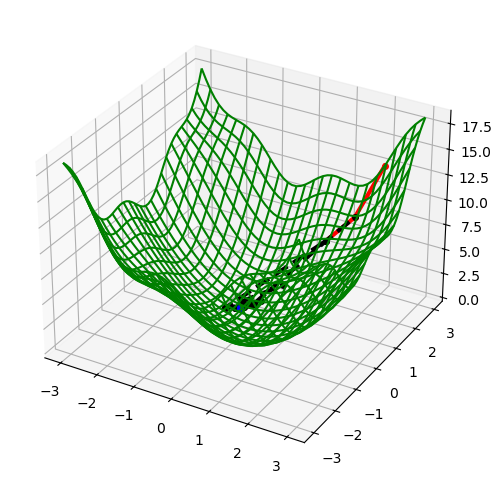

In [60]:
# Example of Nelder-Mead method
import time


def my_func(x_vect: nptyping.ArrayLike):
    x = x_vect[0]
    y = x_vect[1]
    return x**2 + y**2 + np.sin(x * y)


X0 = np.array([[1.0, 2.0], [1.5, 2.5], [2.0, 3.0]]).T
minimum, traj = nelder_mead(my_func, X0, traj=True)
plt.ion()
fig = plt.figure(figsize=(9, 6))
ax = plt.axes(projection="3d")
xrange = np.linspace(-3, 3, 51)
yrange = np.linspace(-3, 3, 51)
xgrid, ygrid = np.meshgrid(xrange, yrange)
zgrid = my_func([xgrid, ygrid])

ax.plot_wireframe(xgrid, ygrid, zgrid, color="green")
num_traj = len(traj[0, 0, :])
for i in range(num_traj):
    x = traj[0, :, i]
    y = traj[1, :, i]
    z = my_func([x, y])
    if i == 0:
        ax.plot(x, y, z, "ro-", linewidth=3, markersize=4)
    elif i == num_traj - 1:
        ax.plot(x, y, z, "bo-", linewidth=3, markersize=4)
    else:
        ax.plot(x, y, z, "ko--", linewidth=3, markersize=4)
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.5)
plt.show()

# Hessian test

In [6]:
def hessian(
    f: typing.Callable[[nptyping.ArrayLike], float], x: nptyping.ArrayLike
) -> np.ndarray:
    n = len(x)
    H = np.zeros((n, n))
    inc = 1e-5

    for i in range(n):
        for j in range(n):
            if i == j:
                x_plus_inc = x.copy()
                x_minus_inc = x.copy()
                x_plus_inc[i] += inc
                x_minus_inc[i] -= inc
                # Second order partial derivative
                H[i, j] = (f(x_plus_inc) - 2 * f(x) + f(x_minus_inc)) / inc**2
            else:
                x_plus_plus_inc = x.copy()
                x_plus_plus_inc[i] += inc
                x_plus_plus_inc[j] += inc

                x_plus_minus_inc = x.copy()
                x_plus_minus_inc[i] += inc
                x_plus_minus_inc[j] -= inc

                x_minus_plus_inc = x.copy()
                x_minus_plus_inc[i] -= inc
                x_minus_plus_inc[j] += inc

                x_minus_minus_inc = x.copy()
                x_minus_minus_inc[i] -= inc
                x_minus_minus_inc[j] -= inc

                H[i, j] = (
                    f(x_plus_plus_inc)
                    - f(x_plus_minus_inc)
                    - f(x_minus_plus_inc)
                    + f(x_minus_minus_inc)
                ) / (4 * inc**2)

    return H

In [7]:
def sample_function(x):
    return x[0] ** 2 + x[1] ** 2


initial_point = np.array([1.0, 2.0])

H = hessian(sample_function, initial_point)

print("My Hessian matrix:")
print(H)

My Hessian matrix:
[[2.00000017 0.        ]
 [0.         2.00000017]]
